# Deep Learning Mini-Challenge 1: Image Classification with Neuronal Networks

**Task description:** The goal of this mini-challenge is the implementation, optimization and evaluation of a neural network model for the classification of an image dataset. The focus is on the training and evaluation of the models. The evaluation is limited to Multi layer Perceptrons (MLP's) and Convolutional neural Networks (CNN's) in combination with different optimization and regularization methods.

**Description of the dataset:** For this mini challenge we use the `CIFAR10` dataset, which is a sub-set of the `Tiny images` dataset. The dataset is named after the **C**anadian **I**nstitute **F**or **A**dvanced **R**esearch. It is an image dataset and contains some 60 000 labelled images that belong to one of 10 classes. The images have a resolution of 32x32 pixels and are in RGB format. 


### Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from multiprocessing import cpu_count
import wandb

import copy
import os
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datetime import datetime
import plotly
import plotly.graph_objects as go
import plotly.express as px

# import functions for explorative data analysis & visualization
from eda_functions import *

os.environ["WANDB_SILENT"] = "True"

### Device configuration
Check for allocated devices that can be used for training of the Models.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Weights and Biases init configuration

To monitor the training of our models and to tune hyperparameters, we use the weights and biasses library.
Its methods can be integrated with only a few lines of code, the program can be used for free and the code is open source. 
For more informations see: https://wandb.ai/site

In [3]:
wandb.login()

True

## Load Dataset

Pytorchs torchvision library offers access to a variety of datasets, including CIFAR10. In a first step, the dataset is downloaded and stored in the data folder of our repository. In the future, our dataset will be automatically accessed from there. 

After that, the dataset gets loaded into the notebook without any transformation to review the data and conduct some analysis. The data is loaded using pytorch's `DataLoader` method. This allows for relatively simple pre-sampling and loading of the data, with the possibility of custom customizing loading order and automatic batching. For this notebook we use a batch size of 32 samples per batch.

In [4]:
def define_dataset(normalize=False, path=None):
    '''Defines the train and testset
    Args:
        normalize (bool): if true normalizes the image
    Returns:
        train_set (torchvision dataset)
        test_set (torchvision dataset)
    '''
    if normalize:
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
        transform = transforms.Compose([transforms.ToTensor(),])

    if not os.path.exists(path):
        os.makedirs(path)

    train_set = torchvision.datasets.CIFAR10(
        root=path, 
        train=True, 
        download=True, 
        transform=transform)

    test_set = torchvision.datasets.CIFAR10(
        root=path, 
        train=False, 
        download=True, 
        transform=transform)

    return train_set, test_set


def define_dataloader(train_set, test_set, batch_size):
    '''Defines the dataloader for the train and test set
    Args:
        train_set (torchvision dataset):
        test_set (torchvision dataset):
        batch_size (int): defines the number of samples per batch
    Returns:
        train_loader
        test_loader
    '''
    train_loader = torch.utils.data.DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True,
        )

    test_loader = torch.utils.data.DataLoader(
        test_set, 
        batch_size=batch_size, 
        shuffle=False,
        )

    return train_loader, test_loader


# load dataset without normalization
batch_size = 32
train_set, test_set =  define_dataset(normalize=False, path='./../../data')
train_loader, test_loader = define_dataloader(train_set, test_set, batch_size)

Files already downloaded and verified
Files already downloaded and verified


### Define class labels

The CIFAR10 dataset contains ten different classes. In the dataset itself, these are represented by the numerical values 0 to 9. In order to be able to check the individual samples better, we create a dictionary that creates a mapping between the numerical class labels and the real class names.

In [5]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
classes_map = dict(zip(range(len(classes)), classes))
classes_map

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Explorative data analysis

### Class balance in training and test set

We now want to check the frequencies of the individual class labels in the training and test sets.

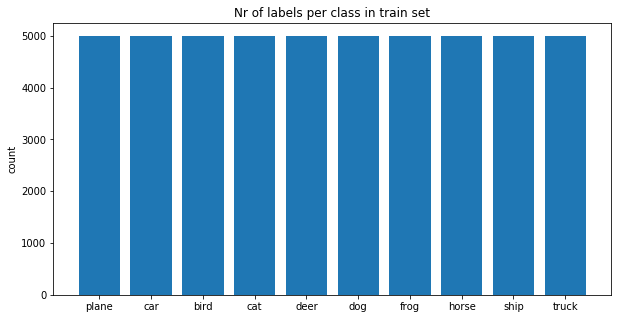

In [6]:
# retrieve train label class count
train_label_count = list()
for samples, labels in train_loader:
    train_label_count.extend(labels.numpy())
train_label_count = {classes_map[i]: train_label_count.count(i) for i in set(train_label_count)}

plt.figure(figsize=(10,5))
plt.bar(list(train_label_count.keys()), list(train_label_count.values()))
plt.title("Nr of labels per class in train set")
plt.ylabel("count")
plt.show()

**Description:** As can be seen in the visualisation above, the training set has balanced class labels. There are 5000 labels per class for all ten classes which results in 50'000 labels total within the trainig set. Next we want to examine the test set.

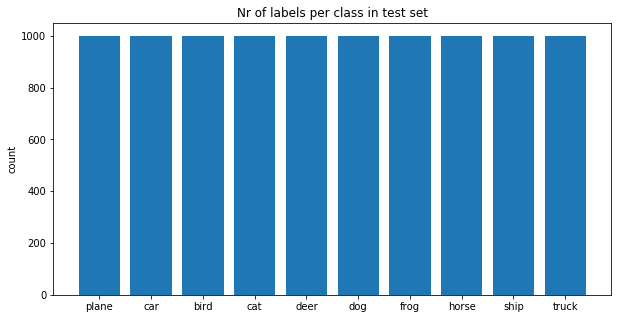

In [7]:
# retrieve test label class count
test_label_count = list()
for samples, labels in test_loader:
    test_label_count.extend(labels.numpy())
test_label_count = {classes_map[i]: test_label_count.count(i) for i in set(test_label_count)}

plt.figure(figsize=(10,5))
plt.bar(list(test_label_count.keys()), list(test_label_count.values()))
plt.title("Nr of labels per class in test set")
plt.ylabel("count")
plt.show()

**Description:** The test set also has balanced class labels. There are 1000 samples per class in the test set which means in total, our test set has 10,000 samples. Knowing the size of the train and test set are able to retrieve calculate the split ratio in the CIFAR10 dataset. The resulting split ratio is therefore 5 to 1 between the train and test set.

### Select sample batch of images

In [8]:
example_batch = iter(train_loader)
samples, labels = example_batch.next()
print("Sample Dimensions:", samples.shape, "\nLabel Dimension:", labels.shape)

Sample Dimensions: torch.Size([32, 3, 32, 32]) 
Label Dimension: torch.Size([32])


**Description:** We now see the dimensions of a selected batch from the training set. The sample dimension is 32, 3, 32, 32. These dimensions are composed as follows:
**32** samples,
**3** colour dimensions (RGB),
**32** pixels image height,
**32** pixels image width.
The label dimension is simply 32 for the labels of the **32** samples.

### Visualization of a single batch

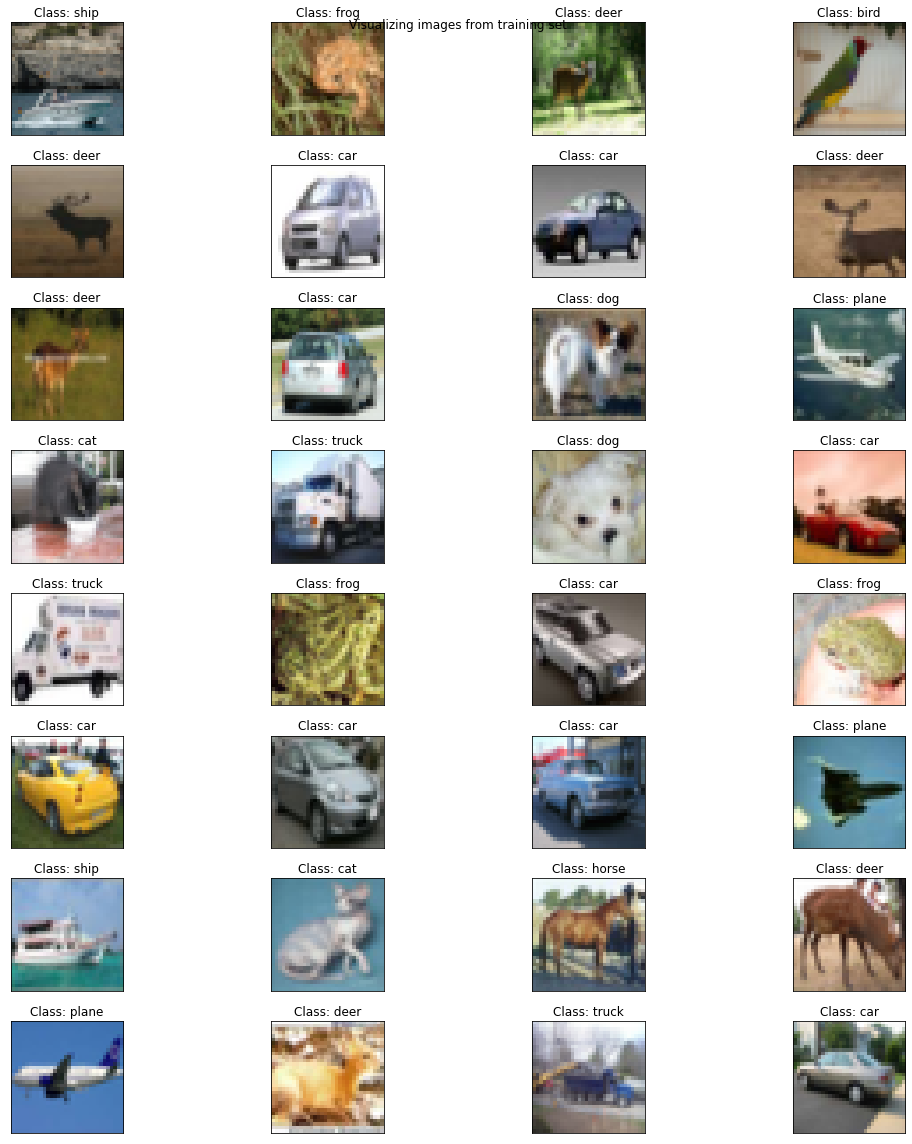

In [9]:
m = 8
n = batch_size // m

fig, axes = plt.subplots(m, n, figsize=(16,16))
for i, image in enumerate(range(batch_size)):
    axes[i//n, i%n].imshow(samples[i].permute(1, 2, 0))
    axes[i//n, i%n].title.set_text("Class: {}".format(classes[labels[i]]))
    axes[i//n, i%n].set_xticks([])
    axes[i//n, i%n].set_yticks([])

plt.suptitle("Visualizing images from training set")
plt.tight_layout()
plt.show()

**Description:** Above we see our randomly drawn training batch. The respective class labels are present in the title. As we can see, the images are not always easy to recognise, even for a human being, due to the low resolution. The biggest advantage of the minimal resolution is the reduction of the features that our model has to take into account, which means that we can use simpler models and correspondingly need less training time.

## Define the target metrics 
In this notebook, a set of metrics are used for the evaluation. 

Since we want to solve a multiclass classification task, the hyperparameter optimization is done primarily by using the cross entropy loss and the balanced accuracy. The score for a perfect prediction would be zero. The initial score of a modell should therefore be higher and start to converge to a lower value. For more information on pytorchs CrossEntropyLoss see: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Because the dataset has the same proportion of labels within each of its classes, the accuracy equals the balanced accuracy. The accuracy varies in theory between 0 which is the worst possible and 1 which is a perfect prediction. In reality, the accuracy score of our models should start at around 0.1 since we have 10 classes, and it is what could be expected on random prediction of untrained models. 


## Define Models
The individual model classes are initialised here.

In [10]:
class MLPNet_2_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 2 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2=None, fc_hidden_3=None, activation=F.relu, drop_out=0):
        super(MLPNet_2_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class MLPNet_3_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 3 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3=None, activation=F.relu, drop_out=0):
        super(MLPNet_3_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class MLPNet_4_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 4 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3, activation=F.relu, drop_out=0):
        super(MLPNet_4_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=fc_hidden_3)
        self.fc4 = nn.Linear(in_features=fc_hidden_3, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
class MLPNet_6_layer(nn.Module):
    '''Multi Layer Perceptron Net class with 4 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3, fc_hidden_4, fc_hidden_5, activation=F.relu, drop_out=0):
        super(MLPNet_6_layer, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=fc_hidden_3)
        self.fc4 = nn.Linear(in_features=fc_hidden_3, out_features=fc_hidden_4)
        self.fc5 = nn.Linear(in_features=fc_hidden_4, out_features=fc_hidden_5)
        self.fc6 = nn.Linear(in_features=fc_hidden_5, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        x = self.activation(self.fc4(x))
        x = self.dropout(x)
        x = self.activation(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [11]:
# load dataset without normalization
train_set, test_set =  define_dataset(normalize=True, path='./../../data')
train_loader, test_loader = define_dataloader(train_set, test_set, batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Define Model Trainer
The `ModelTrainer` class trains the network and logs the metrics that are calculated during training. The class gets as an input the model that needs to be trained, a train-, and test-loader as well as the number of epochs to train, an optimizer as well as a criterion that needs to be optimized.

The `train_loop()` method performs a training epoch on the model. This includes forward propagation, loss calculation, backpropagation and updating the weights. In addition, the loss and the accuracy of the training are returned at the end of the method with the return statement. The `test_loop()` method creates a prediction for all samples on the test set. Then the loss and accuracy for the corresponding epoch is returned in the return statement. Controlling the training is done in the `train()` method. This is where all the methods contained in `ModelTrainer` and required for the training are called up, including logging and early stopping.


To speed the evaluation up, the training per model is stopped after the specified number of epochs is reached or if the top test accuracy did not increase for more than 25 epochs.

In [12]:
class ModelTrainer:
    
    def __init__(self, model, train_loader, test_loader, num_epochs, criterion, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.logger = {
            "train":dict(),
            "test":dict()
        }
        self.best_log = dict()
        self.best_model = None
        
        
    def wandb_log(self, log_dict, e):
        wandb.log(log_dict, step=e)


    def calculate_accuracy(self, pred, true):
        '''Calculates the accuracy for the prediction
        Args: 
            pred: predicted labels
            true: true labels
        Returns:
            accuracy as float
        '''
        return (pred.argmax(1) == true).type(torch.float).sum().item()
    

    def train_loop(self, dataloader, verbose):
        '''
        Loop for a sigle training epoch.
        Args:
            dataloader: pytorch dataloader
        '''
        self.model.train()
        epoch_accuracy = 0
        epoch_loss = 0
        num_batches = len(dataloader)

        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            # Forward propagation
            pred = self.model(images)
            loss = self.criterion(pred, labels)
            
            # Backward propagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # calculate metrics
            epoch_loss += loss.item()
            epoch_accuracy += self.calculate_accuracy(pred, labels)

        epoch_loss /= num_batches
        epoch_accuracy /= len(dataloader.dataset)
        if verbose:
            print(f"train loss:{epoch_loss}, train accuracy:{epoch_accuracy}")
        return {"train loss":epoch_loss, "train accuracy":epoch_accuracy}


    def test_loop(self, dataloader, label="train"):
        self.model.eval()
        epoch_loss = 0
        epoch_accuracy = 0
        num_batches = len(dataloader)

        with torch.no_grad():
            for i, (images, labels) in enumerate(dataloader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward propagation
                pred = self.model(images)

                # calculate metrics
                epoch_loss += self.criterion(pred, labels).item()
                epoch_accuracy += self.calculate_accuracy(pred, labels)
        epoch_loss /= num_batches
        epoch_accuracy /= len(dataloader.dataset)
        return {"{} loss".format(label): epoch_loss, "{} accuracy".format(label): epoch_accuracy}


    def train(self, verbose=False, include_test_scores=False, early_stopping=False):
        # calculate initial model preformance
        self.logger["train"][0] = self.test_loop(self.train_loader, label="train")
        self.wandb_log(self.logger["train"][0], 0)
        if include_test_scores:
            self.logger["test"][0] = self.test_loop(self.test_loader, label="test")
            self.wandb_log(self.logger["test"][0], 0)
            
            # save init as best model
            self.best_log = self.logger["test"][0]
            self.best_model = copy.deepcopy(self.model)
            self.logger["test"][0]["top test accuracy"] = self.logger["test"][0]["test accuracy"]
            self.wandb_log({"top test accuracy":self.best_log["test accuracy"]}, 0)
            

        for e in range(self.num_epochs):
            if verbose:
                print(f"Epoch: {e+1} ------------------------------")
            
            # train model
            self.logger["train"][e+1] = self.train_loop(self.train_loader, verbose)
            self.wandb_log(self.logger["train"][e+1], e+1)

            # calculate model preformance
            if include_test_scores:
                self.logger["test"][e+1] = self.test_loop(self.test_loader, label="test")
                self.wandb_log(self.logger["test"][e+1], e+1)

                # secure model with best test score
                if self.best_log["test accuracy"] < self.logger["test"][e+1]["test accuracy"]:
                    self.best_log = self.logger["test"][e+1]
                    self.best_model = copy.deepcopy(self.model)
                self.logger["test"][e+1]["top test accuracy"] = self.best_log["test accuracy"]
                self.wandb_log({"top test accuracy":self.best_log["test accuracy"]}, e+1)
                
                # stop if test accuracy stops increasing for 25 epochs
                if (e >= 25) and early_stopping:
                    if self.best_log["test accuracy"] == self.logger["test"][e-24]["top test accuracy"]:
                        break



In [13]:
# num_epochs = 3
# model = ConvNet_5(
#             conv1_channels=120,
#             conv2_channels=120,
#             conv3_channels=120,
#             conv4_channels=120,
#             conv5_channels=120).to(device) # model selection
# learning_rate = 0.01        # learning rate for optimizer
# l2_weight_decay = 0.0       # l2 regularization for optimizer

# trainer = ModelTrainer(
#     model=model, 
#     train_loader=train_loader, 
#     test_loader=test_loader, 
#     num_epochs=num_epochs,
#     criterion=nn.CrossEntropyLoss(),
#     optimizer=torch.optim.SGD(
#         model.parameters(), 
#         lr=learning_rate,
#         weight_decay = l2_weight_decay
#         )
#     )

# trainer.train(verbose=True, include_test_scores=True)
# trainer.logger

## Evaluate Model Size

### MLP architecture

In a first step we want to train a simple MLP with variable number of layers and nodes to see how well it is able to learn the trainigset and to use the trained network for evaluation of the classifications on the testset. The Multilayer Perceptron recieves the input data as a one-dimensional vector per image or as a two-dimensional matrix for multiple images. 

The structure of the network contains **1**, **2**, **3**, or **5** hidden layers. The nummber of nodes per layer varies between **32**, **64**, **128** and **256** nodes. We train four models for each structural combination with a varying learning rate of **0.02**, **0.05**, **0.1** and **0.2**. This results in **4 * 4 * 4 = 64** different trained mlp's.

### CNN architecture

The architecture of a Convolutional Neural Network extends the existing structure of our MLP's with Convolutional Layers, followed by a Pooling Layer. The convolutional layer receives as input our 2 dimensional images and the three colour channels (RGB) as a 3d matrix. Then a filter kernel is iterated over the pixels of the matrix window by window. The output for a single pixel is calculated as the scalar product of the iterated window and the filter kernel. The output dimension of the Concolutional Layer can be calculated using the formula below.

</br>

$$H_{out} = \left\lfloor\frac{H_{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$

$$W_{out} = \left\lfloor\frac{W_{in} + 2 \times \text{padding}[1] - \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

where

- $W_{in}$: Width of input
- $H_{in}$: Height of input

The subsequent pooling layer is used to filter out excess information. Here, again, a window is iterated over the output of the convolutional layer and a pooling action is performed. The most common method is max pooling, but average pooling is also used for deeper neural networks. This reduces the features of our matrices, while it usually does not reduce the accuracy of our network. Due to the feature reduction, our network is not only faster in computation and training, but it is also possible to train deeper networks. Furthermore, this method prevents overfitting, since the individual features are viewed in a generalised manner within the local iterated window. 


The structure of the cnn contains **2**, **3**, or **5** convolutional layers followed by a pooling layer. The nummber of filter kernel per convolutional layer varies between **32**, **64**, **128** and **256** filters. And like before we train four models for each structural combination with a varying learning rate of **0.02**, **0.05**, **0.1** and **0.2**. This results in **3 * 4 * 4 = 48** different trained cnn's.

In [14]:
class ConvNet_2(nn.Module):
    '''A convolutional neural network with 2 convolutional layers'''
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, conv1_channels = 10, conv2_channels=8, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''Convolutional Net class'''
        super(ConvNet_2, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size) 
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.dropout2d = nn.Dropout2d(drop_out)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size) 
        self.fc1 = nn.Linear(in_features=conv2_channels*5*5, out_features=fc_hidden_1)   
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv2_channels = conv2_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv2(x)))
        x = self.dropout2d(x)
        x = x.view(-1, self.conv2_channels*5*5) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

class ConvNet_3(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, padding=3, conv1_channels = 10, conv2_channels=8, conv3_channels=8, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''A convolutional neural network with 3 convolutional layers'''
        super(ConvNet_3, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.dropout2d = nn.Dropout2d(drop_out)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding)
        self.fc1 = nn.Linear(in_features=conv3_channels*5*5, out_features=fc_hidden_1)   
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv3_channels = conv3_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv3(x)))
        x = self.dropout2d(x)
        x = x.view(-1, self.conv3_channels*5*5) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    
class ConvNet_5(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, padding=3, conv1_channels = 16, conv2_channels=16, conv3_channels=16, conv4_channels=16, conv5_channels=16, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''A convolutional neural network with 3 convolutional layers'''
        super(ConvNet_5, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.dropout2d = nn.Dropout2d(drop_out)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding)
        self.conv4 = nn.Conv2d(in_channels=conv3_channels, out_channels=conv4_channels, kernel_size=kernel_size, padding=padding)
        self.conv5 = nn.Conv2d(in_channels=conv4_channels, out_channels=conv5_channels, kernel_size=kernel_size, padding=padding)
        self.fc1 = nn.Linear(in_features=conv5_channels*2*2, out_features=fc_hidden_1)   
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv5_channels = conv5_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv3(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv4(x)))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv5(x)))
        x = self.dropout2d(x)
        x = x.view(-1, self.conv5_channels*2*2) # flatten tensor
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Train models

As a last setup, a function is created that contains the initialisation of our model, the ModelTrainer, the subsequent training, logging and saving of the best models. In itself, this function is not really necessary, but it allows us to prepare individual packages of constellations that we can then simply recall afterwards, which saves the repetition of code.

In [15]:
def save_model(path, model, name):
        '''
        Saves the model as state dict.
        Args:
            path (str): path where to save the model
        '''
        filename = "/{}.pt".format(name)
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model, path + filename)
        

def train_mlp_2(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_2_layer(
            fc_hidden_1=config["hidden_layers"][0],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)


def train_mlp_3(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_3_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)


def train_mlp_4(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_4_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            fc_hidden_3=config["hidden_layers"][2],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_mlp_6(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_6_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            fc_hidden_3=config["hidden_layers"][2],
            fc_hidden_4=config["hidden_layers"][3],
            fc_hidden_5=config["hidden_layers"][4],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_cnn_2(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_2(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_cnn_3(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_3(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            conv3_channels=config["conv_layers"][2],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
            
def train_cnn_5(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_5(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            conv3_channels=config["conv_layers"][2],
            conv4_channels=config["conv_layers"][3],
            conv5_channels=config["conv_layers"][4],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)

## Model Evaluation

In this section, different model constelations are examined for their performance. The evaluation is done by using Baesiean Search. The optimization is done with respect to the accuracy.

### Training of MLP's with SGD (without REG, without BN)

In [ ]:
num_epochs = 100
min_acc = 0.5
create_sweep = False #create new sweeps

# create initial sweep configuration
mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "MLP_SGD"
        },
        "num_hidden": {
            "value": 1
        },
        "hidden_layers": {
            "values":[(32,), (64,), (128,), (256,)]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.2, 0.1, 0.05, 0.02]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
    }
}

# run 2 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_2)

    
# update sweep configuration for 3 layers mlp
mlp_sweep_configuration["parameters"].update({
    "num_hidden": {"value": 2},
    "hidden_layers": {"values":[(32,32), (64,64), (128,128), (256,256)]}})
# run 3 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_3)

    
# update sweep configuration for 4 layers mlp
mlp_sweep_configuration["parameters"].update({
    "num_hidden": {"value": 3},
    "hidden_layers": {"values":[(32,32,32), (64,64,64), (128,128,128), (256,256,256)]}})
# run 4 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_4)

    
# update sweep configuration for 6 layers mlp
mlp_sweep_configuration["parameters"].update({
    "num_hidden": {"value": 5},
    "hidden_layers": {"values":[(32,32,32,32,32), (64,64,64,64,64), (128,128,128,128,128), (256,256,256,256,256)]}}) 
# run 6 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_6)

### Training of CNN's with SGD (without REG, without BN)

In [ ]:
num_epochs = 100
min_acc = 0.75
create_sweep = False #create new sweeps

# create initial sweep configuration
cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "CNN_SGD"
        },
        "num_conv": {
            "value": 2
        },
        "conv_layers": {
            "values": [(32, 32),(64, 64),(128,128),(256,256)]
        },
        "num_hidden": {
            "value": 2
        },
        "hidden_layers": {
            "values": [(128, 64),]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.2, 0.1, 0.05, 0.02]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}

# run 2 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_2)

    
# update sweep configuration for 3 layers cnn
cnn_sweep_configuration["parameters"].update({
    "num_conv": {"value": 3},
    "conv_layers": {"values":[(32,32,32), (64,64,64), (128,128,128), (256,256,256)]}})
# run 3 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_3)

    
# update sweep configuration for 5 layers cnn
cnn_sweep_configuration["parameters"].update({
    "num_conv": {"value": 5},
    "conv_layers": {"values":[(32,32,32,32,32), (64,64,64,64,64), (128,128,128,128,128), (256,256,256,256,256)]}})
# run 5 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_5)

### Evaluation

In [ ]:
df_config_summary, df_history_summary = read_wandb_logs()
df_history_max_test_acc = df_history_summary.loc[df_history_summary.groupby(["name"])["test accuracy"].idxmax()].reset_index(drop=True)
df_history_max_test_acc = pd.merge(df_history_max_test_acc, df_config_summary, left_on="name", right_on="name")

In [ ]:
def print_best_models(df, variant=None):
    '''Prints the best model vor a specified variant'''
    # select model variant
    if variant:
        df = df.loc[df["variant"]==variant]
    # select model with best test accuracy
    df = df.loc[df["top test accuracy"]==np.max(df["top test accuracy"])]
    print("Best \033[1m{}\033[0m model reached a test accuracy of \033[1m{}\033[0m at epoch \033[1m{}\033[0m with and test loss of \033[1m{:.3f}\033[0m".format(
        df["variant"].values[0], 
        df["test accuracy"].values[0],
        df["_step"].values[0].astype(int), 
        df["test loss"].values[0]
    ))

print_best_models(df_history_max_test_acc, variant="MLP_SGD")
print_best_models(df_history_max_test_acc, variant="CNN_SGD")

**Description:** The best MLP achieved a test accuracy of **0.549**, the best CNN **0.808**. The cnn thus performs significantly better on previously unseen data. It is noticeable that the best mlp has the maximum test accuracy already in epoch **13** while the cnn performed best on the test set in epoch **79**. We want to examine the resulting scores in more detail in our next steps.

#### MLP metrics development

In [ ]:
show_training(df = pd.merge(df_history_summary, df_config_summary, left_on="name", right_on="name"), 
              variant = "MLP_SGD", 
              columns = ["train loss", "test loss", "train accuracy", "test accuracy", "top test accuracy"])

**Description:** We see that the training loss converges relatively stable towards a minimum for all models. The training accuracy is similar, which shows us that our mlp's work correctly in terms of training. If we compare the training and test loss, we see that the test loss reaches a minimum fairly early on. Then the test loss starts to increase again, while the training loss continues to decrease, which indicates an over fitting of the model.

If we compare the test loss with the test accuracy, we see that the test accuracy also reaches the best result around the same time as the test loss. Afterwards, the test accuracy decreases again, but less severely than the test loss. This may be due to the fact that the model causes a sharp increase in the test loss due to the overfitting of the training data set, but the classification with the absolute labels remains approximately the same.

The colors reflect the learning rate of the network. 
- yellow: 0.2
- red: 0.1
- pink: 0.05
- violett: 0.02

There seems to be a correlation between the learning rate and the effectiveness of the training. After the inspection of the cnn metrics we will therefore investigate the effect of the learning rate on the test accuracy.

#### CNN metrics development

In [ ]:
show_training(df = pd.merge(df_history_summary, df_config_summary, left_on="name", right_on="name"), 
              variant = "CNN_SGD", 
              columns = ["train loss", "test loss", "train accuracy", "test accuracy", "top test accuracy"])

**Description:** 



For the CNNs we see a much faster convergence of the loss functions. Here, we also see an overfitting of most models from about the 10th epoch onwards, propably because of the same reasons as with the mlp's.

The learning rate is again color coded in the visualization. 
- yellow: 0.2
- red: 0.1
- pink: 0.05
- violett: 0.02


With the CNN, we can clearly see how the learning rate can influence the training.The learning rate of 0.2 and 0.1 is clearly too high, which can be seen in the explosion of the loss function during training. With the higher learning rates, the optimum for the test accuracy and the test loss is also reached relatively early in the training. For lower learning rates the highest test accuracy score can be reached later in training. For this reason, in the next step we would like to take a closer look at the learning rate per model variant.

#### Influence of learning rate on training

In [ ]:
compare_learning_rates_per_model(df_history_max_test_acc)

The visualization shows the best achieved test accuracy according to model variant and learning rate. It can be seen that an increase in the learning rate led to a deterioration in the best test accuracy across all variants. For this reason, I would recommend using a learning rate of **0.05** or less on our data set for training with the mlp as well as the cnn.

The visualization also shows the difference between the generalization ability of the MLP and the CNN variants. Finally we want to investigate the influence of the number of layers and the number of nodes per layer. 

#### MLP influence of  layer constellations

In [ ]:
compare_mlp_sizes(df_history_max_test_acc, variant="MLP_SGD")

**Description:** Looking the heat map, some interesting things can be observed:

1. It is noticeable that increasing the number of nodes per layer across all layer constellations has led to an improvement in the maximum test accuracy. The best variants based on our test set are those with the maximum tested number of 256 nodes per layer. 


2. Comparing the different numbers of layers, it can be seen that the variants with only one hidden layer performed clearly worse than the variants with more than one hidden layer for all layer sizes (except for layer size 32). The variants between 2 and 5 hidden layers have top test accuracy scores within the same hidden layer size that are much closer to each other.

Based on this result, I would suggest that an MLP on our training data is therefore only partially able to generalise in such a way that it can reliably classify new samples. An extension of layers does not lead to a significant improvement after 2 to 3 layers. 


 #### CNN influence of  layer constellations

In [ ]:
compare_cnn_sizes(df_history_max_test_acc, variant="CNN_SGD")

As with the MLP, let's look at the best test accuracy for the CNN constalations.

**Description:** When looking at the heat map, we also see an improvement in the best achieved test accuracy with an increasing number of filter kernels per convolutional layer. Thus, the model is able to extract more relevant features from the data set which can be used by the subsequent fully connected layers for the classifiaction task.

It can also be seen that an increase in the number of convolutional layers leads to an improvement. This shows us that our model can generate more complex features with more convolutional layers, which are apparently also relevant for the classification of unseen data.

## Inclusion of Regularization

### L2 Regularization

The Ridge regression adds the “squared magnitude” of all weights as penalty a term to the loss function. It is relevant how strongly the regularization is weighted in the calculation of the cost function. The strength of the regularization can be set via the hyperparameter *lambda*: $\lambda$. If lambda is 0, then the regularization is not included in the optimization, which corresponds to the OLS variant used before. The higher lambda is chosen, the more the individual weights are decreased. L2 regularization therefore disperse the error terms in all the weights which should leads to more generalized final models.

#### Training of MLP's with SGD (with L2 REG, without BN)

In [ ]:
num_epochs = 100
min_acc = 0.5
create_sweep = False #create new sweeps

# create initial sweep configuration
mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "MLP_SGD_L2"
        },
        "num_hidden": {
            "value": 3
        },
        "hidden_layers": {
            "values": [(256,256,256),] 
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "value": 0.05
        },
        "l2_weight_decay": {
            "values": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
        },
        "drop_out": {
            "value": 0
        },
    }
}


# run 4 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_4)

#### Training of CNN's with SGD (with L2 REG, without BN)

In [ ]:
num_epochs = 100
min_acc = 0.75
create_sweep = False #create new sweeps

# create initial sweep configuration
cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "CNN_SGD_L2"
        },
        "num_conv": {
            "value": 5
        },
        "conv_layers": {
            "values": [(256,256,256,256,256),]
        },
        "num_hidden": {
            "value": 2
        },
        "hidden_layers": {
            "values": [(128, 64),]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "value": 0.05
        },
        "l2_weight_decay": {
            "values": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


# run 5 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_5)

### Evaluation

In [ ]:
df_config_summary, df_history_summary = read_wandb_logs()
df_history_max_test_acc = df_history_summary.loc[df_history_summary.groupby(["name"])["test accuracy"].idxmax()].reset_index(drop=True)
df_history_max_test_acc = pd.merge(df_history_max_test_acc, df_config_summary, left_on="name", right_on="name")
df_l2 = pd.merge(df_history_summary, df_config_summary, left_on="name", right_on="name")

In [ ]:
print_best_models(df_history_max_test_acc, variant="MLP_SGD_L2")
print_best_models(df_history_max_test_acc, variant="CNN_SGD_L2")

**Description:** Now including l2 regularization, the best MLP achieved a test accuracy of **0.551** compared to **0.549** (regularized MLP), the best CNN **0.807** compared to **0.808** (regularized CNN). It seems that the l2 regularization did not really improve the top score of both models.

However, we see that the maximum test accuracy is now reached later in training for both best models. From epoch **13** to **15** for the MLP and from epoch **79** to **93** for the CNN. We want to analyze if this effect is actually caused by the l2 and examine the influence of l2 regularization on the training further in the following code cells.

#### MLP: L2 effect on train loss vs test loss  and  train accuracy vs best test accuracy

In [ ]:
plot_train_vs_test_loss(df_l2, "MLP_SGD_L2")

**Description:** The visualization shows the training loss per epoch against the test loss per epoch for the mlp model. We see in the visualization that both test and training loss decrease at the beginning. At a certain point, however, the test loss starts to increase again which is where the model starts to overfit. With increasing regularization strength, the minimum train loss seems to decrease on the one hand, and on the other hand, the training and test loss get closer to each other. However, if the regularization is too strong, both the training and the test loss are prevented from reaching a satisfactory minimum.

In [ ]:
plot_train_vs_test_accuracy(df_l2, "MLP_SGD_L2")

**Description:** The visualization shows the training accuracy per epoch against the best reached test accuracy per epoch for the mlp model. Again, we see how the training and test accuracy increase at the same rate at the beginning. With an increasing number of epochs, however, the increase in test accuracy decreases disproportionately and seems to converge to a limit. Furthermore, we see that the value of the training accuracy and the maximum test accuracy converge strongly with increasing l2-regularization.

In [ ]:
max_test_acc_bar(df_l2, "MLP_SGD_L2")

**Description:** The visualization shows the maximum reached test accuracy for different l2 regularization values of our mlp model. Looking only at the maximum reached test accuracy, we see a pattern between the l2 regularization parameter and the performance of the model. It seems that a regularization parameter of around **0.001** and **0.002** led to a better model. 

#### CNN: L2 effect on train loss vs test loss  and  train accuracy vs best test accuracy

In [ ]:
plot_train_vs_test_loss(df_l2, "CNN_SGD_L2")

**Description:** The visualization shows the training loss per epoch against the test loss per epoch for the cnn model. We see that the model can learn the data set perfectly after 100 epochs without regularization. An increase of the regularization leads to a "barrier", which the training loss converges to. With an increasing regularization strength this "barrier" becomes higher. From a l2 regularization of 0.005 upwards, the model learns so poorly that neither the training loss nor the test loss can be relevantly reduced.

In [ ]:
plot_train_vs_test_accuracy(df_l2, "CNN_SGD_L2")

**Description:** The visualization shows the training accuracy per epoch against the best reached test accuracy per epoch for the cnn model. Due to the cnn's ability to generalize more, we see much less overfitting here and it also also starts to overfitt later in the training compared to the mlp. We also clearly see an effect of the l2 regularization on the training of the model. From a regulation strength of 0.005 upwards, the training seems to make no significant progress anymore, which results in a termination of the training from our early stopping criteria after 25 epochs. Therefore, the models with a higher l2 parameter are stuck in the bottom left of the plot around the initialization score.

In [ ]:
max_test_acc_bar(df_l2, "CNN_SGD_L2")

**Description:** The visualization shows the maximum reached test accuracy for different l2 regularization values. We now see that our best cnn model appears to be the one without regularization. All regularized models degrade the maximum test accuracy achieved. From a l2 regularization of 0.005 upwards, the best test scores are barely bether than the initial expected accuracy because the training stoped after a short time due to a lack of progress in the training accuracy.

### Drop out Regulatization

With drop out regularization, a specified percentage of the output values of the nodes within a layer are swept out and their value is set to zero. The selection of the nodes occurs randomly and is repeated for each batch. By ignoring individual node outputs in training, it ensures that the model cannot solely rely on individual nodes for making a classification. This causes the individual edge weights to be lowered overall, which should produce an effect similar to that of L2 regularization.

#### Training of MLP's with SGD (with Dropout REG, without BN)

In [ ]:
num_epochs = 100
min_acc = 0.5
create_sweep = True #create new sweeps

# create initial sweep configuration
mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "MLP_SGD_DP"
        },
        "num_hidden": {
            "value": 3
        },
        "hidden_layers": {
            "values": [(256,256,256),] 
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "value": 0.05
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "values": [0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
    }
}


# run 4 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_4)

#### Training of CNN's with SGD (with Dropout REG, without BN)

In [ ]:
num_epochs = 100
min_acc = 0.75
create_sweep = True #create new sweeps

# create initial sweep configuration
cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "CNN_SGD_DP"
        },
        "num_conv": {
            "value": 5
        },
        "conv_layers": {
            "values": [(256,256,256,256,256),]
        },
        "num_hidden": {
            "value": 2
        },
        "hidden_layers": {
            "values": [(128, 64),]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "value": 0.05
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "values": [0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


# run 5 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_5)

### Evaluation

In [ ]:
df_config_summary, df_history_summary = read_wandb_logs()
df_history_max_test_acc = df_history_summary.loc[df_history_summary.groupby(["name"])["test accuracy"].idxmax()].reset_index(drop=True)
df_history_max_test_acc = pd.merge(df_history_max_test_acc, df_config_summary, left_on="name", right_on="name")
df_dp = pd.merge(df_history_summary, df_config_summary, left_on="name", right_on="name")

In [ ]:
print_best_models(df_history_max_test_acc, variant="MLP_SGD_DP")
print_best_models(df_history_max_test_acc, variant="CNN_SGD_DP")

**Description:** Now including dropout regularization, the best MLP achieved a test accuracy of **0.544** compared to **0.549** (regularized MLP), the best CNN **0.810** compared to **0.808** (regularized CNN). Again, no significant improvement seems to have been achieved through using dropout as regularization method. However, we still want to investigate how dropout affected learning behavior in our models.

#### MLP: Drop out effect on train loss vs test loss  and  train accuracy vs best test accuracy

In [ ]:
plot_train_vs_test_loss(df_dp, "MLP_SGD_DP")

**Description:** The visualization shows the training loss per epoch against the test loss per epoch for the mlp model with dropout regularization. Compared to the l2 regularization, the training loss does not converge to an invisible limit. However, the training happens with increasing regularization strength at a reduced speed.

In [ ]:
plot_train_vs_test_accuracy(df_dp, "MLP_SGD_DP")

**Description:** The visualization shows the training accuracy per epoch against the best reached test accuracy per epoch for the mlp model with dropout regularization. It seems that the train accuracy and best test accuracy seem to slowly decrease with a higher dropout ratio.

In [ ]:
max_test_acc_bar(df_dp, "MLP_SGD_DP")

**Description:** Looking at the best test scores for our dropout, we see, that the best score was achieved with a dropout of two percent. It can be observed that there is a drop-off in the best accuracy with an increasing dropout ratio, however compared to the l2 regularization, the reduction is far less steep.

#### CNN: Drop out effect on train loss vs test loss  and  train accuracy vs best test accuracy

In [ ]:
plot_train_vs_test_loss(df_dp, "CNN_SGD_DP")

**Description:** The visualization shows the training loss per epoch against the test loss per epoch for the cnn model. Here it can also be observed that the training speed slows down with an increased dropout ratio. The overfitting starts around at the same train loss level as with the l2 regularization. The train loss however still reaches a level close to zero despite the dropout. 

In [ ]:
plot_train_vs_test_accuracy(df_dp, "CNN_SGD_DP")

**Description:** The visualization shows the training accuracy per epoch against the best test accuracy per epoch for the cnn model with dropout regularization. Apart from the fact that the models with a higher dropout require more training epochs to achieve the same accuracy, I can't see any significant difference between the different regulation strengths.

In [ ]:
max_test_acc_bar(df_dp, "CNN_SGD_DP")

**Description:** Finally, if we compare the maximum achieved test acccuracy of our different dropout ratios, we see that a low dropout worked best. 

### Including Batchnorm BN (without REG)

Batchnormalization is a popular method to improve the training of deep neural networks, where there is an effect that can occur with an extended number of layers: the so-called *internal covariance shift*. This describes the phenomenon when the distribution of the activation values of a layer is changed by adjusting the weights of the prior layer. The adjustments of all preceding layers thus have an influence on the distributions of all activations of subsequent layers. The subsequent layers therefore must adapt to these changes. As a result, the training is significantly slowed down.

Batch normalisation aims, as the name suggests, to normalise the distribution of activation values per batch for each layer, which reduces the variation of activation values per layer to a more defined range. Batch normalisation can thus also be seen as a kind of smoothing of the cost function in each layer, which in turn reduces the variation of the gradient lengths and thus leads to a more stable learning behaviour.

In [16]:
# redefine models
class MLPNet_4_layer_bn(nn.Module):
    '''Multi Layer Perceptron Net class with 4 layers'''
    def __init__(self, fc_hidden_1, fc_hidden_2, fc_hidden_3, activation=F.relu, drop_out=0):
        super(MLPNet_4_layer_bn, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3, out_features=fc_hidden_1)
        self.fc1_bn = nn.BatchNorm1d(fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc2_bn = nn.BatchNorm1d(fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=fc_hidden_3)
        self.fc3_bn = nn.BatchNorm1d(fc_hidden_3)
        self.fc4 = nn.Linear(in_features=fc_hidden_3, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation # activation function
    
    def forward(self, x):
        batch_size  = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.activation(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.activation(self.fc3_bn(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


class ConvNet_5_bn(nn.Module):
    def __init__(self, activation=F.relu, kernel_size=5, pool_size=2, padding=3, conv1_channels = 16, conv2_channels=16, conv3_channels=16, conv4_channels=16, conv5_channels=16, fc_hidden_1=120, fc_hidden_2=84, drop_out=0):
        '''A convolutional neural network with 3 convolutional layers'''
        super(ConvNet_5_bn, self).__init__()   
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding)
        self.conv1_bn=nn.BatchNorm2d(conv1_channels)
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        self.dropout2d = nn.Dropout2d(drop_out)
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding)
        self.conv2_bn=nn.BatchNorm2d(conv2_channels)
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding)
        self.conv3_bn=nn.BatchNorm2d(conv3_channels)
        self.conv4 = nn.Conv2d(in_channels=conv3_channels, out_channels=conv4_channels, kernel_size=kernel_size, padding=padding)
        self.conv4_bn=nn.BatchNorm2d(conv4_channels)
        self.conv5 = nn.Conv2d(in_channels=conv4_channels, out_channels=conv5_channels, kernel_size=kernel_size, padding=padding)
        self.conv5_bn=nn.BatchNorm2d(conv5_channels)
        self.fc1 = nn.Linear(in_features=conv5_channels*2*2, out_features=fc_hidden_1)
        self.fc1_bn = nn.BatchNorm1d(fc_hidden_1)
        self.fc2 = nn.Linear(in_features=fc_hidden_1, out_features=fc_hidden_2)
        self.fc2_bn = nn.BatchNorm1d(fc_hidden_2)
        self.fc3 = nn.Linear(in_features=fc_hidden_2, out_features=10)
        self.dropout = nn.Dropout(drop_out)
        self.activation = activation
        self.conv5_channels = conv5_channels

    def forward(self, x):
        x = self.pool(self.activation(self.conv1_bn(self.conv1(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv2_bn(self.conv2(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv3_bn(self.conv3(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv4_bn(self.conv4(x))))
        x = self.dropout2d(x)
        x = self.pool(self.activation(self.conv5_bn(self.conv5(x))))
        x = self.dropout2d(x)
        x = x.view(-1, self.conv5_channels*2*2) # flatten tensor
        x = self.activation(self.fc1_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.activation(self.fc2_bn(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    
# redefine training methods
def train_mlp_4_bn(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_4_layer_bn(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            fc_hidden_3=config["hidden_layers"][2],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)
    
    
def train_cnn_5_bn(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_5_bn(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            conv3_channels=config["conv_layers"][2],
            conv4_channels=config["conv_layers"][3],
            conv5_channels=config["conv_layers"][4],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)

#### Training of MLP's with SGD (without REG, with BN)

In [18]:
num_epochs = 100
min_acc = 0.5
create_sweep = True #create new sweeps

# create initial sweep configuration
mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "MLP_SGD_BN"
        },
        "num_hidden": {
            "value": 3
        },
        "hidden_layers": {
            "values": [(256,256,256),] 
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.02, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
    }
}


# run 4 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_4_bn)

Create sweep with ID: 3cgdjcql
Sweep URL: https://wandb.ai/simonluder/del-mc1/sweeps/3cgdjcql


#### Training of CNN's with SGD (without REG, with BN)

In [ ]:
num_epochs = 100
min_acc = 0.75
create_sweep = True #create new sweeps

# create initial sweep configuration
cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "CNN_SGD_DP"
        },
        "num_conv": {
            "value": 5
        },
        "conv_layers": {
            "values": [(256,256,256,256,256),]
        },
        "num_hidden": {
            "value": 2
        },
        "hidden_layers": {
            "values": [(128, 64),]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0.02, 0.05]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}


# run 5 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_5)

Create sweep with ID: zf98peb1
Sweep URL: https://wandb.ai/simonluder/del-mc1/sweeps/zf98peb1


### Evaluation

### Using Adam (without BN)

In [ ]:
num_epochs = 100
min_acc = 0.5
create_sweep = True #create new sweeps

# create initial sweep configuration
mlp_sweep_configuration = {
    "name": "MLP_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "MLP_SGD_Adam"
        },
        "num_hidden": {
            "value": 3
        },
        "hidden_layers": {
            "values": [(256,256,256),] 
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values":[0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
    }
}

# redefine training
def train_mlp_4_adam(config=None):
    '''Trains and logs a multilayer perceptron'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = MLPNet_4_layer(
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            fc_hidden_3=config["hidden_layers"][2],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)


# run 4 layer mlp
if create_sweep:
    sweep_id = wandb.sweep(mlp_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_mlp_4_Adam)

In [ ]:
num_epochs = 100
min_acc = 0.75
create_sweep = True #create new sweeps

# create initial sweep configuration
cnn_sweep_configuration = {
    "name": "CNN_sweep",
    "metric": {"name": "test accuracy", "goal": "minimize"},
    "method": "grid",
    "parameters": {
        "variant": {
            "value": "CNN_SGD_Adam"
        },
        "num_conv": {
            "value": 5
        },
        "conv_layers": {
            "values": [(256,256,256,256,256),]
        },
        "num_hidden": {
            "value": 2
        },
        "hidden_layers": {
            "values": [(128, 64),]
        },
        "num_epochs": {
            "value": num_epochs
        },
        "learning_rate": {
            "values": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
        },
        "l2_weight_decay": {
            "value": 0
        },
        "drop_out": {
            "value": 0
        },
        "kernel_size": {
            "value": 5
        },
        "pool_size": {
            "value": 2
        },
    }
}

# redefine training
def train_cnn_5_adam(config=None):
    '''Trains and logs a convolutional neuronal network'''
    with wandb.init(entity="simonluder", config=config) as run:
        config = wandb.config
        wandb.run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
        
        # define model
        model = ConvNet_5(
            kernel_size=config["kernel_size"],
            pool_size=config["pool_size"],
            conv1_channels=config["conv_layers"][0],
            conv2_channels=config["conv_layers"][1],
            conv3_channels=config["conv_layers"][2],
            conv4_channels=config["conv_layers"][3],
            conv5_channels=config["conv_layers"][4],
            fc_hidden_1=config["hidden_layers"][0],
            fc_hidden_2=config["hidden_layers"][1],
            drop_out=config["drop_out"],
            ).to(device) 
        
        # define trainer
        trainer = ModelTrainer(
            model=model, 
            train_loader=train_loader, 
            test_loader=test_loader, 
            num_epochs=config["num_epochs"],
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(
                model.parameters(), 
                lr=config["learning_rate"],
                weight_decay = config["l2_weight_decay"]))
        
        #train model
        trainer.train(verbose=False, include_test_scores=True, early_stopping=True)
        # save model if minimal test accuracy-score is reached
        if trainer.best_log["test accuracy"] >= min_acc:
            save_model(path="top_model", model=trainer.best_model, name=wandb.run.name)

# run 5 cnn 2 mlp layer
if create_sweep:
    sweep_id = wandb.sweep(cnn_sweep_configuration, project="del-mc1", entity="simonluder")
    wandb.agent(sweep_id, function=train_cnn_5)

### Evaluation

The first noticeable change is the change in the optimal learning rate. While our previous variants had an optimal learning rate between 0.1 and 0.05, with the Adam optimizer this rate is clearly too high and leads to an unstable learning behaviour. It seems that for our models in the CIFAR10 data set, a 10 times smaller learning rate is necessary to achieve a stable training behaviour.